In [1]:
import pysam
import deepchopper
from deepchopper import (
    remove_intervals_and_keep_left,
)
from deepchopper.utils import highlight_targets
from pathlib import Path
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import logging
from rich.logging import RichHandler
from needletail import (
    parse_fastx_file,
    NeedletailError,
)

import seaborn as sns
import re
from textwrap import wrap
import gget

FORMAT = "%(message)s"
logging.basicConfig(
    level=logging.WARN,
    format=FORMAT,
    handlers=[RichHandler()],
)


@dataclass
class FqRecord:
    id: str
    seq: str
    qual: str

    def to_str(self):
        return f"{self.id}\n{self.seq}\n+\n{self.qual}"


def vis_qual_static(
    predict, start: int | None = None, end: int | None = None, figure_size=(20, 1)
):
    if predict.qual is None:
        raise ValueError("no qual, please fetch qual first")

    start = 0 if start is None else start
    end = len(predict.seq) if end is None else end

    qual = np.array([ord(c) - 33 for c in list(predict.qual[start:end])]).reshape(1, -1)
    seq = list(predict.seq[start:end])

    # Creating the heatmap
    fig, ax = plt.subplots(
        figsize=figure_size
    )  # Set a wide figure to accommodate the sequence
    cax = ax.imshow(qual, aspect="auto", cmap="viridis")
    cbar = plt.colorbar(cax, ax=ax, orientation="vertical")
    cbar.set_label("Value")
    # Setting up the sequence as x-axis labels
    ax.set_xticks(np.arange(len(seq)))
    ax.set_xticklabels(seq, rotation=90)  # Rotate labels for better readability
    # Remove y-axis labels as there's only one row
    ax.set_yticks([])
    ax.set_title(f"{predict.id}: {start}-{end}")
    plt.show()
    plt.close()


def print_seq(predict, regions):
    print(f"id     : {predict.id}")
    print(f"regions: {regions}")
    highlight_targets(predict.seq, regions)


def compare_smooth(predict, smooth_window_size: int):
    regions = predict.prediction_region

    window_size = smooth_window_size
    smooth_regions = predict.smooth_prediction_region(window_size)

    print(f"id      : {predict.id}")
    print(f"original: {regions}")
    print(f"smooth  : {smooth_regions}")
    highlight_targets(predict.seq, regions)
    highlight_targets(predict.seq, smooth_regions)


def chop_intervals(
    predict, *, smooth: bool, smooth_window_size: int | None
) -> list[tuple[int, int]]:
    if smooth:
        if smooth_window_size is None:
            raise ValueError("please provide window size")
        window_size = smooth_window_size
        regions = predict.smooth_prediction_region(window_size)
    else:
        regions = predict.prediction_region
    return regions


def to_fqs_record(predict, intervals: list[tuple[int, int]]):
    if predict.qual is None:
        raise ValueError("no qual, please fetch qual first")

    assert len(predict.qual) == len(predict.seq)

    seqs, saved_intervals = remove_intervals_and_keep_left(predict.seq, intervals)
    quals, saved_intervals = remove_intervals_and_keep_left(predict.qual, intervals)

    assert len(seqs) == len(quals)
    for ind, (seq, qual) in enumerate(zip(seqs, quals, strict=True)):
        record_id = f"@{predict.id}|{saved_intervals[ind][0], saved_intervals[ind][1]}"
        yield FqRecord(id=record_id, seq=seq, qual=qual)


def smooth_and_select_intervals(
    predict_id,
    stats,
    smooth_window_size: int,
    min_interval_length: int,
    approved_interval_nums: int = 1,
) -> list[tuple[int, int]]:
    chop_intervals = stats.smooth_intervals[predict_id]

    results = []
    for interval in chop_intervals:
        if interval[1] - interval[0] > min_interval_length:
            results.append(interval)

    if len(results) > approved_interval_nums:
        return []

    return results


def collect_fq_records(file: Path):
    result = {}
    try:
        for record in parse_fastx_file(file.as_posix()):
            result[record.id] = record
    except NeedletailError:
        print("Invalid Fastq file")

    return result


def collect_sam_records(file: Path):
    if not isinstance(file, Path):
        file = Path(file)

    result = {}
    samfile = pysam.AlignmentFile(file.as_posix(), "rb")

    for read in samfile.fetch():
        result[read.query_name] = read

    return result


def vis_hist_for_num_of_intervals(
    data, figsize=(10, 6), title=None, ax=None, set_xticks=False
):
    # Create histogram with a kernel density estimate
    max_x = max(data) + 1
    if ax is None:
        plt.figure(figsize=figsize)
        sns.histplot(
            data, kde=True, color="#66c2a5", line_kws={"linewidth": 2}, discrete=True
        )
        if set_xticks:
            plt.xticks(range(0, max_x, 1))
        plt.title(title)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
    else:
        sns.histplot(
            data,
            kde=True,
            color="#66c2a5",
            line_kws={"linewidth": 2},
            discrete=True,
            ax=ax,
        )
        ax.set_title(title)
        if set_xticks:
            ax.set_xticks(range(0, max_x, 1))
        ax.set_xlabel("Value")
        ax.set_ylabel("Frequency")


def wrap_str(ostr, width):
    return "\n".join(wrap(ostr, width))


def show_sam_record(predict, stats, sam_records):
    pat_left_s = re.compile(r"^(\d+)S")
    pat_right_s = re.compile(r"(\d+)S$")

    seq_len = len(predict.seq)
    txt_width = 120

    print(f"\nread id {predict.id} seq len: {seq_len}")

    smooth_intervals = stats.smooth_intervals[predict.id]

    for interval in smooth_intervals:
        quals = predict.qual_array()[interval[0] : interval[1]]
        average_qual = sum(quals) / len(quals)
        print(
            f"smooth interval : {interval} len: {interval[1] - interval[0]}     {average_qual=}"
        )

    highlight_targets(predict.seq, predict.prediction_region())
    highlight_targets(predict.seq, smooth_intervals)

    predict_read = sam_records.get(predict.id, None)
    if predict_read is None:
        print("the read is not map")
        return

    if len(smooth_intervals) == 1:
        blat_df = gget.blat(
            predict.seq[smooth_intervals[0][0] : smooth_intervals[0][1]]
        )
        if blat_df is not None:
            print(f"blat result:\n {blat_df.to_string()}\n")

    print(
        f"{predict_read.reference_id=} strand={'+' if predict_read.is_forward else '-'} {predict_read.mapping_quality=}"
    )
    print(f"{predict_read.reference_start=} {predict_read.reference_end=}")
    print(f"cigar: {wrap_str(predict_read.cigarstring, txt_width)}")

    left_mat = pat_left_s.search(predict_read.cigarstring)
    right_mat = pat_right_s.search(predict_read.cigarstring)
    ls_len = int(left_mat.group(1)) if left_mat else 0
    rs_len = int(right_mat.group(1)) if right_mat else 0

    if not predict_read.is_forward:
        ls_len, rs_len = rs_len, ls_len

    print(f"ls: 0-{ls_len}  \n {wrap_str(predict.seq[:ls_len], txt_width)}")
    print(
        f"rs: {seq_len-rs_len}-{seq_len} \n {wrap_str(predict.seq[-rs_len:], txt_width)}"
    )

    if predict_read.has_tag("SA"):
        print("has sa")
        chimeric_alns = predict_read.get_tag("SA")[:-1].split(";")

        for _aln in chimeric_alns:
            (
                chr_sa,
                pos_sa,
                strand_sa,
                cigar_sa,
                mapq_sa,
                nm_sa,
            ) = _aln.split(",")

            left_mat = pat_left_s.search(cigar_sa)
            right_mat = pat_right_s.search(cigar_sa)

            l_s_len = left_mat.group(1) if left_mat else ""
            r_s_len = right_mat.group(1) if right_mat else ""

            tgt_key = f"{predict_read.qname}\t{l_s_len=}\t{r_s_len=}"

            print(f"chimeric : {tgt_key}")


def check_overlap(
    interval1: tuple[int, int], interval2: tuple[int, int], overlap_threshold: float
) -> bool:
    # interval2 is predicted region

    start1, end1 = interval1
    start2, end2 = interval2

    length1 = end1 - start1
    length2 = end2 - start2

    # Calculate the maximum start point and minimum end point
    max_start = max(start1, start2)
    min_end = min(end1, end2)

    # union
    min_start = min(start1, start2)
    max_end = max(end1, end2)

    # Calculate the overlap length
    overlap = max(0, min_end - max_start)

    divide = length2

    ratio = overlap / divide

    # Check if the overlap meets or exceeds the threshold
    print(f"compare {interval1}({length1}) {interval2}({length2}) {ratio=}")
    return ratio >= overlap_threshold


def process_one_interval(
    overlap_results,
    whole_seq_len: int,
    predict,
    ls_len: int,
    rs_len: int,
    pd_start: int,
    pd_end: int,
    overlap_threshold: float,
    internal_threshold: float,
    blat_threshold: float,
    read_mp: int,
    min_mapping_quality: int,
):
    predict_seq = predict.seq[pd_start:pd_end]
    min_blat_seq_len = 20

    if pd_end / whole_seq_len > internal_threshold:
        # terminal adapter
        # has overlap
        if check_overlap(
            (whole_seq_len - rs_len, whole_seq_len),
            (pd_start, pd_end),
            overlap_threshold,
        ):
            overlap_results["terminal_chop_sc"].append(predict.id)
        else:
            overlap_results["terminal_chop_nosc"].append(predict.id)
            if len(predict_seq) < min_blat_seq_len:
                overlap_results["terminal_chop_nosc_cannot_blat"].append(predict.id)
                return

            blat_df = gget.blat(predict_seq)
            if blat_df is not None:
                print(f"\nblat_df: {blat_df.to_string()}\n")
            else:
                print("blat_df is None")

            if blat_df is None or (blat_df.iloc[0]["%_aligned"] / 100 < blat_threshold):
                overlap_results["terminal_chop_nosc_noblat"].append(predict.id)

    else:  # internal adapter
        flag = False
        if ls_len != 0:
            if check_overlap((0, ls_len), (pd_start, pd_end), overlap_threshold):
                flag = True
                overlap_results["internal_chop_sc"].append(predict.id)

        if rs_len != 0 and not flag:
            if check_overlap(
                (whole_seq_len - rs_len, whole_seq_len),
                (pd_start, pd_end),
                overlap_threshold,
            ):
                flag = True
                overlap_results["internal_chop_sc"].append(predict.id)

        if not flag:
            overlap_results["internal_chop_nosc"].append(predict.id)

            if len(predict_seq) < min_blat_seq_len:
                # seq is too short, and cannot use blat
                overlap_results["internal_chop_nosc_cannot_blat"].append(predict.id)
                return

            blat_df = gget.blat(predict_seq)
            if blat_df is not None:
                print(f"\nblat_df: {blat_df.to_string()}\n")
            else:
                print("blat_df is None")

            if blat_df is None or (blat_df.iloc[0]["%_aligned"] / 100 < blat_threshold):
                overlap_results["internal_chop_nosc_noblat"].append(predict.id)



def verify_result_with_sam_records(
    overlap_results,
    predict,
    stats,
    sam_records,
    internal_threshold: float = 0.85,
    overlap_threshold: float = 0.4,
    blat_threshold: float = 0.9,
    min_mapping_quality: int = 0,
):
    pat_left_s = re.compile(r"^(\d+)S")
    pat_right_s = re.compile(r"(\d+)S$")

    predict_read = sam_records.get(predict.id, None)

    if predict_read is None:
        print(f"\nthe read {predict.id} is not map")
        overlap_results["unmap_read"].append(predict.id)
        return

    if predict_read.mapping_quality < min_mapping_quality:
        print(
            f"\nthe read {predict.id}'s mapping_quality {predict_read.mapping_quality} is low"
        )
        overlap_results["low_mp_read"].append(predict.id)
        return

    seq_len = len(predict.seq)

    left_mat = pat_left_s.search(predict_read.cigarstring)
    right_mat = pat_right_s.search(predict_read.cigarstring)
    ls_len = int(left_mat.group(1)) if left_mat else 0
    rs_len = int(right_mat.group(1)) if right_mat else 0

    intervals = stats.smooth_intervals[predict.id]

    if not predict_read.is_forward:
        ls_len, rs_len = rs_len, ls_len

    # highlight_targets(predict.seq, intervals)
    print("\n")
    print(predict.show_info(intervals))

    txt_width = 120
    print(
        f"{predict_read.reference_id=} strand={'+' if predict_read.is_forward else '-'} {predict_read.mapping_quality=}"
    )
    print(f"{predict_read.reference_start=} {predict_read.reference_end=}")
    print(f"cigar: {wrap_str(predict_read.cigarstring, txt_width)}")
    print(f"ls {ls_len}: 0-{ls_len}  \n {wrap_str(predict.seq[:ls_len], txt_width)}")
    print(
        f"rs {rs_len}: {seq_len-rs_len}-{seq_len} \n {wrap_str(predict.seq[seq_len-rs_len:seq_len], txt_width)}"
    )

    # if predict_read.has_tag("SA"):

    if len(intervals) == 1:
        # clean predict
        start, end = intervals[0]
        # quals = predict.qual_array()[start:end]
        # average_qual = sum(quals) / len(quals)
        process_one_interval(
            overlap_results,
            seq_len,
            predict,
            ls_len,
            rs_len,
            start,
            end,
            overlap_threshold,
            internal_threshold,
            blat_threshold,
            predict_read.mapping_quality,
            min_mapping_quality,
        )
    elif len(intervals) == 2:
        for interval in intervals:
            start, end = interval
            process_one_interval(
                overlap_results,
                seq_len,
                predict,
                ls_len,
                rs_len,
                start,
                end,
                overlap_threshold,
                internal_threshold,
                blat_threshold,
                predict_read.mapping_quality,
                min_mapping_quality,
            )
    else:
        overlap_results["no_process"].append(predict.id)
        pass


from collections import defaultdict

def verify_result_with_sam_records_for_parallel(
    predict,
    stats,
    sam_records,
    internal_threshold: float = 0.85,
    overlap_threshold: float = 0.4,
    blat_threshold: float = 0.9,
    min_mapping_quality: int = 0,
):

    overlap_results = defaultdict(list)
    
    pat_left_s = re.compile(r"^(\d+)S")
    pat_right_s = re.compile(r"(\d+)S$")

    predict_read = sam_records.get(predict.id, None)

    if predict_read is None:
        print(f"\nthe read {predict.id} is not map")
        overlap_results["unmap_read"].append(predict.id)
        return

    if predict_read.mapping_quality < min_mapping_quality:
        print(
            f"\nthe read {predict.id}'s mapping_quality {predict_read.mapping_quality} is low"
        )
        overlap_results["low_mp_read"].append(predict.id)
        return

    seq_len = len(predict.seq)

    left_mat = pat_left_s.search(predict_read.cigarstring)
    right_mat = pat_right_s.search(predict_read.cigarstring)
    ls_len = int(left_mat.group(1)) if left_mat else 0
    rs_len = int(right_mat.group(1)) if right_mat else 0

    intervals = stats.smooth_intervals[predict.id]

    if not predict_read.is_forward:
        ls_len, rs_len = rs_len, ls_len

    # highlight_targets(predict.seq, intervals)
    print("\n")
    print(predict.show_info(intervals))

    txt_width = 120
    print(
        f"{predict_read.reference_id=} strand={'+' if predict_read.is_forward else '-'} {predict_read.mapping_quality=}"
    )
    print(f"{predict_read.reference_start=} {predict_read.reference_end=}")
    print(f"cigar: {wrap_str(predict_read.cigarstring, txt_width)}")
    print(f"ls {ls_len}: 0-{ls_len}  \n {wrap_str(predict.seq[:ls_len], txt_width)}")
    print(
        f"rs {rs_len}: {seq_len-rs_len}-{seq_len} \n {wrap_str(predict.seq[seq_len-rs_len:seq_len], txt_width)}"
    )

    # if predict_read.has_tag("SA"):

    if len(intervals) == 1:
        # clean predict
        start, end = intervals[0]
        # quals = predict.qual_array()[start:end]
        # average_qual = sum(quals) / len(quals)
        process_one_interval(
            overlap_results,
            seq_len,
            predict,
            ls_len,
            rs_len,
            start,
            end,
            overlap_threshold,
            internal_threshold,
            blat_threshold,
            predict_read.mapping_quality,
            min_mapping_quality,
        )
    elif len(intervals) == 2:
        for interval in intervals:
            start, end = interval
            process_one_interval(
                overlap_results,
                seq_len,
                predict,
                ls_len,
                rs_len,
                start,
                end,
                overlap_threshold,
                internal_threshold,
                blat_threshold,
                predict_read.mapping_quality,
                min_mapping_quality,
            )
    else:
        overlap_results["no_process"].append(predict.id)
        pass

    return overlap_results

def merge_results(results_list):
    combined_results = defaultdict(list)
    for single_result in results_list:
        for key, values in single_result.items():
            combined_results[key].extend(values)
    return combined_results

**TODO**: 

- [ ] summary chop  or not chop
- [ ] summary chop internal or terminal
- [ ] chop only has one interval
- [ ] summary chop interval size

In [2]:
sam_records = collect_sam_records("/projects/b1171/ylk4626/project/DeepChopper/data/eval/real_data/dorado_without_trim_fqs/VCaP.bam")

In [3]:
len(sam_records)

8201131

In [9]:
test_chunks = [Path("/projects/b1171/ylk4626/project/DeepChopper/tests/data/eval/chunk0"),
               Path("/projects/b1171/ylk4626/project/DeepChopper/tests/data/eval/chunk1")]       

In [30]:
fq_records = collect_fq_records(Path("/projects/b1171/ylk4626/project/DeepChopper/data/eval/real_data/dorado_without_trim_fqs/VCaP.fastq"))

In [31]:
len(fq_records)

9177639

In [5]:
## VCaP
hyena_results = [
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_0/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_1/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_2/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_3/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_4/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_5/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_6/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_7/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_8/predicts/0/"),
Path("/projects/b1171/ylk4626/project/DeepChopper/logs/eval/runs/vcap/VCaP.fastq_9/predicts/0/"),
]

In [6]:
max_batches  =  1000
all_predicts = deepchopper.load_predicts_from_batch_pts(hyena_results[0],
                                                        -100, 
                                                        max_batches)

Tue Apr 23 16:30:31 2024 INFO Found 31250 pt files
Tue Apr 23 16:30:31 2024 INFO only load first 1000 pt files


In [7]:
%time
len(all_predicts)

CPU times: user 6 µs, sys: 2 µs, total: 8 µs
Wall time: 16.5 µs


32000

In [8]:
# %%time
# time_stats = deepchopper.py_collect_statistics_for_predicts(
#     list(all_predicts.values()),
#     smooth_window_size=27,
#     min_interval_size=10,
#     approved_interval_number=5,
#     internal_threshold=0.7,
#     ploya_threshold=3,
# )
# time_stats

In [9]:
%%time
stats = deepchopper.py_collect_statistics_for_predicts_parallel(
    list(all_predicts.values()),
    smooth_window_size=21,
    min_interval_size=10,
    approved_interval_number=5,
    internal_threshold=0.85,
    ploya_threshold=3,
)
stats

CPU times: user 18.6 s, sys: 23 ms, total: 18.6 s
Wall time: 308 ms


StatResult(total_predicts: 30235,  predicts_with_chop: 28228, smooth_predicts_with_chop: 27728,
                        smooth_internal_predicts: 509, total_truncated: 0, smooth_only_one: 27303,
                        smooth_ploya_only_one: 22553)

In [10]:
print(all_predicts[stats.predicts_with_chop[0]].show_info(stats.smooth_intervals[stats.predicts_with_chop[0]]))

id: 26ffc9fd-bd40-427e-8c94-42f2bb2470eb
prediction: [2164..2236]
smooth_intervals: [(2164, 2236)]
TTGGCGCTCAAGCATGGCGGCGAGCGGCATTTGGGCAGCTCCGGGCTCGCGTCCCCGGCCGTGGCTGAGCTCTGCCAGAA
CACCCCGGAGACCTTTTTGGAGGCCTCCAAGCTGCTGCTTCCTATGCTAACAACCTCAGAAACCCTAATGATGAAAAATA
TAGATCCATCCGGATTGGAAACACAGCCTTTTCTACTAGACTCTTGCCTGTCAGAGGAGCTGTTGAATGTTTATTTGAAT
GGGCTTTGAAGAGGGAGAAACACATCTCATCTTTCCTAAAAAAGCTTCAGTGGAGCAGCTGCAAAAAATTTTGACCTGAT
TGCCATAGAGAGAAGTAGCAGACTGGATGGCTCAAATAAGAGCCACAAAGTAAAGTCATCTCAGCAACCTGCAGCCAGTA
CCCAGCTTCCTACAACACCATCAAATCCCAGTGGGTTAAACCAGCACACAAGGAACCGTATAAGGGCAGTCATCAGATCC
ACCATCTGCTTCAACGGTTGCTGCTGACTCAGCCATTTTAGAAGTTCTTCAGTCCAACATTCAGCATGTGCTGGTCTATG
AAAAATCCTGCTCTTCAGGGAGAAAGCGTTGGCTTGTATTCCGGTCCAAGAACTAAAAAGGAATCACAAGAAAAGTTATC
GAGAGCTAGAAAATTGGATAAAGGTATCAATATAAGTGATGAGGATTTTCTTTTGCTGGAGCTTTTTGCACTGGTTTAAG
GAATAGCAGAATTTTTTCACTGGGTGAATAACGTTTGTGCAGCAAATGTGGTGGACAGACTAGGTCTGAGAGATAGATCA
TTACTGCCCAGTGATGATGAGCTGAAGTGGGGTGCAAAGGAAGTGGAAGATACTGTGATGCCTGCCAGTTCAGCAATCGA
TTCCCAAGAT

In [51]:
for pid, p in all_predicts.items():
    p.qual =  fq_records[p.id].qual

In [52]:
len(stats.smooth_internal_predicts)

528

In [53]:
len(stats.smooth_predicts_with_chop)

27783

In [13]:
ps  = stats.smooth_predicts_with_chop
len(ps)

for p in ps[:1000]:
    pd = all_predicts[p]
    # show_sam_record(pd, stats, sam_records)
    sreg = stats.smooth_intervals.get(p, [])
    if len(sreg) > 2:
        print("\n")
        print(pd.show_info(sreg))



id: 584d1d29-b0f7-4561-beda-8b530380c918
prediction: [3396..3462, 3467..3468, 3469..3473, 3491..3493, 3497..3512, 3513..3517, 3540..3543, 4345..4346, 4355..4356, 4357..4358, 4360..4361, 4369..4371, 4373..4375, 4379..4385, 4386..4392, 4393..4401, 4405..4409, 4411..4412]
smooth_intervals: [(3396, 3467), (3495, 3516), (4376, 4412)]
ATGGCCGGCGACATTAGCTAGCGCTTGCACATTACCTCTCTAACGGGAAAGCAGCGGAATACAAGAGACTGAACTGTATC
TGCCTCTATTTCCAAAAGGACCACGTTCAACTTCGCTCACACAAAGCCGGGAAAATTTTATTAGTCCTCTTTTAAAAAAA
GTTAATATAAAATTATAGCAAAAAAAAAAGGAACCTGAACTTTAGTAACACAGCTGGAACAATCCGCAGCGGCGGCAGCG
GCGGGAGAAGAGGTTTAATTTAGTTGATTTTCTGTGGTTGTTGGTTGTTCAAATACCACGGTGATGGAAGCTGCACATTT
TCGAAGGGACCGAGAAGCTGCTGGTTTGGTTCTCCCGGCAGCAGCCCGACGCAAACCAAGGATTTGGGATCTTCGCACTA
TCCCAAGATCTGAGTGGGACATACTTTTGAAGGATGTGCAATGTTCAATCATAAGTGTGACAAAAACTGACAAGCAGGAA
GCTTATGTACTCAGTGAGAGTAGCATGTTTGTCTCCAAGAGACGTTTCATTTTGAAGACATGTGGTACCACCCTCTTGCT
GAAAGCACTGGTTCCCCTGTTGAAGCTTGCTCAGGGATTACAGTGGGTTCTGACTTCTCAATTCAAAGCTTCTTTTATTC
TGCGTAAGAATTTCATGAA

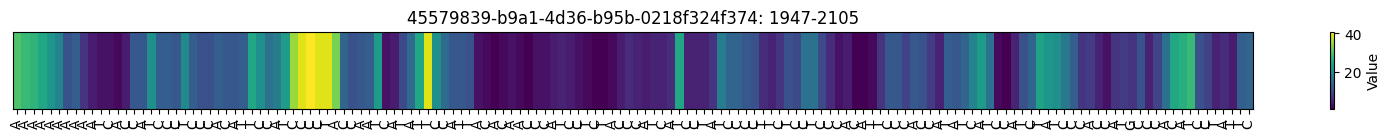

In [54]:
p = stats.predicts_with_chop[0]
vis_qual_static(all_predicts[p], stats.smooth_intervals[p][0][0] - 10 , stats.smooth_intervals[p][0][1] + 10)

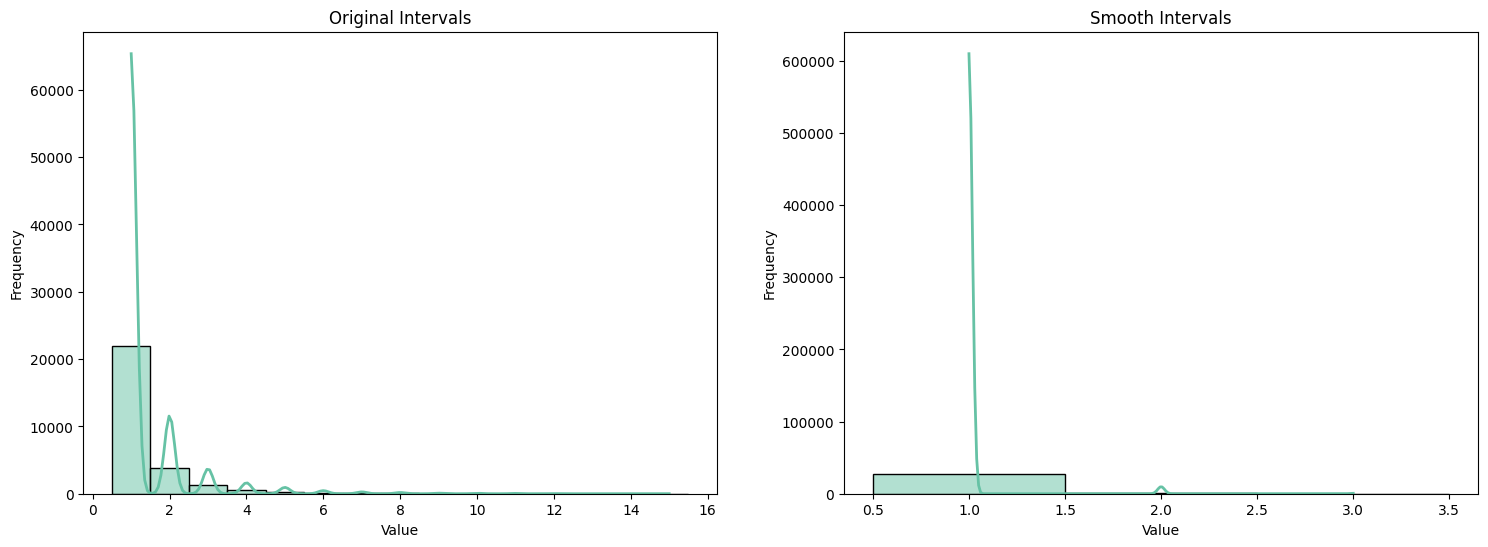

In [55]:
original_prediction_number = stats.number_predicts_with_chop(all_predicts)
smooth_prediction_number = stats.number_smooth_predicts_with_chop()

fig, axs = plt.subplots(1, 2, figsize=(18, 6))
vis_hist_for_num_of_intervals(original_prediction_number, title="Original Intervals", ax=axs[0])
vis_hist_for_num_of_intervals(smooth_prediction_number, title="Smooth Intervals", ax=axs[1])

In [56]:
len(stats.smooth_only_one_with_ploya)

22387

In [57]:
plot_oregion_size_data = stats.length_predicts_with_chop(all_predicts)
plot_sregion_size_data = stats.lenghth_smooth_predicts_with_chop()

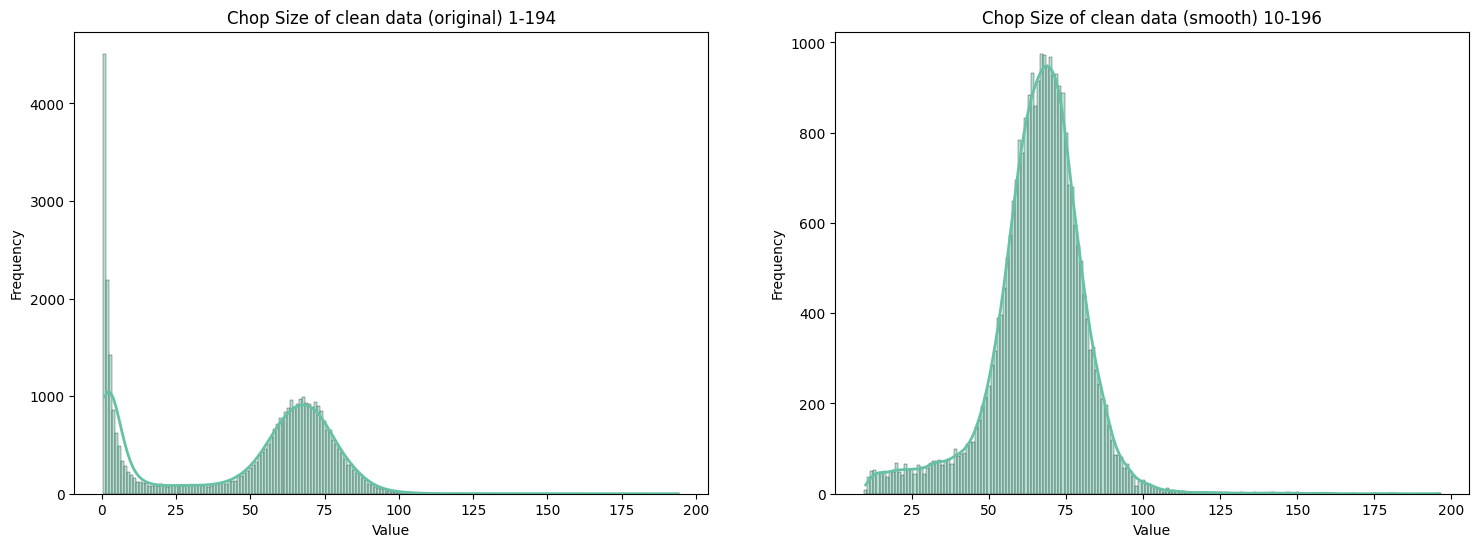

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
vis_hist_for_num_of_intervals(plot_oregion_size_data, title=f"Chop Size of clean data (original) {min(plot_oregion_size_data)}-{max(plot_oregion_size_data)}", ax=axs[0])
vis_hist_for_num_of_intervals(plot_sregion_size_data, title=f"Chop Size of clean data (smooth) {min(plot_sregion_size_data)}-{max(plot_sregion_size_data)}", ax=axs[1])

In [59]:
len(stats.smooth_only_one)

27318

In [60]:
len(stats.smooth_predicts_with_chop)

27783

In [41]:
def show_examples(predcit_ids, all_predicts, stats):
    for predict_id in predcit_ids:
        predict = all_predicts[predict_id]
        
        smooth_regs = stats.smooth_intervals.get(predict_id, [])
        print(predict.show_info(smooth_regs))

In [29]:
show_examples(set(stats.smooth_predicts_with_chop) - set(stats.smooth_only_one), all_predicts, stats)

id: 110600e3-9f28-4241-b251-97da6085885f
prediction: [889..959, 2024..2092, 2093..2094, 2095..2096, 2097..2099]
smooth_intervals: [(889, 959), (2024, 2099)]
GTTCTGCCGTCCTGGGGCGGGGGACGTTTTGGACAGTGGGGTAAACTGAGGCCCGATAGGGGCGCTAGGCACTGCCCGGA
GTCCGGCGCGCACGGATTGAGGCGACCTGATTCCGCCGCATCCTGGCCCGCGCGGCGAGTGTGGTCTCTGGGCTCGGGAC
CTGACTTCTGGCCTGGGGGCCGTGCACCGGCAGCGCAGGATTCAGCCTCTTCCAACTGGCCCTGAGACCACTTTGCGACT
GACCCCGGAGGCTGGAATGCAGTGGTGTGATCTTGGCTCACTGCAGCCTCTACCACCTGGGCTCAAGCAATCTTCCCACC
TCGGCCTCCCAAGTAGCTGGAACTACAGGTGGCCCCAAATCCAAGCAATCCTTATAAGAGAGAGACAGAGGGAGATTTGA
GAGACAGAAGAGGAGGAGGTGATCTGATTACAGAGGCGGAGACGGGTAATGCCCATGCGCCCGAGTTCCCCGGCAGCCAC
TGGAAGCTGGAGAGGTGAGGAGTCGCCCAGGAGGCCCTGAGGGAGCTAGATCAAGTTGCGGCCTCCAGAACTCCAGAGAG
AATGAATGTCTGCTGTTCTCAGCACCCCTCCGTGGTCCTCTGTCACGGCAGCCGCGGGACCCTCACGCGCTGTCTGGGCC
GTCCCTTCCAGCGTGTCGGGCGTTGTGTCCAGCACTGGGACCGCCCTCAGGCGTGACTTGAGCCCTGTTCCAGCCTCTGC
GCGGGGTTGCCCAGACGCCCCTCCAGGGCGTGATGCCACTGCCCCTGGTGGCCGCGGCTGCCCAGACGCCTCTCCTCGCA
GACCCAGCACCGCCAGCACTTGGGAACCAGCTC

In [15]:
# overlap_results
# overlap_results
def vis_overlap_results(data):
    import pandas as pd
    plot_df  =  pd.DataFrame([(key, len(value)) for key, value in data.items()], columns=['Category', 'Count'])
    # Plotting the data
    plt.figure(figsize=(10, 6))  # Set the figure size
    bars = plt.bar(plot_df['Category'], plot_df['Count'], color='skyblue')  # Create a bar chart
    # Add text annotations to the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')

    plt.xlabel('Category')  # Set the x-label
    plt.ylabel('Number of Items')  # Set the y-label
    plt.title('Count of Items in Each Category')  # Set the title
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
    plt.tight_layout()  # Adjust layout to make room for the rotated x-labels
    plt.show()  # Display the plot
    plt.close()

In [22]:
from collections import defaultdict
ps  = stats.smooth_predicts_with_chop

overlap_results  = defaultdict(list)
# ps = set(os) - set(stats.smooth_internal_predicts)
for p in ps[1000:2000]:
    pd = all_predicts[p]
    # sreg = stats.smooth_intervals.get(p, [])
    # if len(sreg) > 2:
        # show_sam_record(pd, stats, sam_records)
        # print("\n")
        # print(pd.show_info(sreg))
    
    verify_result_with_sam_records(
    overlap_results,
    pd,
    stats,
    sam_records,
    internal_threshold = 0.85,
    overlap_threshold  = 0.4,
    blat_threshold  = 0.9,
    min_mapping_quality = 0)



id: 3ebd7257-061f-456c-a566-f05e78ebaccc
prediction: [1604..1685]
smooth_intervals: [(1604, 1685)]
GGTCCTCGGAGACACGCGGCGGTGTCCTGTGTTGGCCATGGCCGACTACCTGATTAGATAGGGGCACGTCCATGCCAGAC
GACGGACTCACAGCACAGCAGCTTCAACTGCGGAGACGGCCTCACCTACAATGACCTTTTTATTACCCTAGTCGCATCGA
CTTTCTGACCAGGTGGACCTGACTTCTGCTCTGACCTGAGAAAATCATTTAAGACCCCACTGGTTTCCACCCTTTTAGAC
ACAGTCACAGAGGCTGGGATGGCATAGCAATGGCGCTTCAGGCGGTATTGGCTTCATCCACACAACTGTACACCTGAATT
CCAGGCCAATGAGTACCACAGTAAAGTGAAGAAATATGAACAGGGATTCATCCGGACTCACCTGTGGTCCTCAGCCCCAA
GGATCGCGTGCGGGATGTCTTCGAGGCCAAGGCCCGGCATGGTTTGCGGTATCCCAATCACAGACCCGCAGGCCGGATGG
GGAGCCGCTTGGGTGGGGCATCATCCCAGGGACATTGATTTCAAGAGGAACATGACATTGTTTCTTGGAAGTTTTGACAA
AGGGAAGACTTGGTGGTAGCCCCTGCAGGCATCACACTGAAGGCAAAATGAAATTCTGCAGCGCAGCAAGAAGGAAAGTT
GCCCATTGTAAATGAAGATGATGAGCTTGTGGCCATCATTGCCCGGACAGACCTGAAGAATCGGGACTACCCACTAGCCT
CCAAAGATGCCAAGAAACAGCTGCTGTGTGGAGGCAGCCATTGGCAAAGAGGATGACAAGTATAGGCTGGTCTTGCTCGC
CCAGGCTGGTGTTGATGTAGTGGTTTTGGACTCTTCCCAGGGAAATTCCATCTTCCAGATCAATATGATCAAGTACATAA
GACAAATA

Tue Apr 23 16:37:07 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.




id: f726409a-3629-4ac7-9c4b-92b029e9db0d
prediction: [857..859, 860..925]
smooth_intervals: [(858, 929)]
TAAGATGCCGAAAGGAAGGCCAAGGGAAAGAAGGTGGCTCCTGCCCCAGCTGTTGTGAAGAAGCAGGAGGCTCTAAGGAA
AAAGTGTTTGAATCCCAATCTGAGAAAAGGCCTAAGAATTTTGGCTGACAGGACCCTGGCCCATAAAAGAGACCTCACCT
ATCTTGTGAATTGGCCCCGCTATATCAGGTTGCAGCAGAGGAGCCATCCTTATAAGCGGCTGAAAGTGCCCACTGCGCAA
TAACCAGTTCACCCAGGCCCTGGACCGCCAAACAGCTACTCAGCTGCTTAAGCTGGCCCACATCAGTACAGACCAGAGGA
CAAAGCAAGAGAAGAAGCGGTGAGACTGTTGCCCGGGCCGAGAAGAAGGCTGCTGGCAAAGGGGACGTCCCAACGATAGA
GACCACCCTGTCCTTCGAGCAGGAGTTAACACCCTTGGTGGAGATCAAGTGGCTCAGCTGGTGGTGATTGTTTCCATGCC
TTGATCCCATCATGAGCTGAGTTAGTTCTCTGCCTGCCCTGTGTTGTAAATGGGGGTCCCACTGTTAAGGAAAGGCTCAA
GACTGGGACGTTTGTCCCACAGGAAGACCTGCACCACTGTCGCCTTTTGCAGGTGAACTCTGAAGACAAAGGCGCTTCTG
GCTAAGCTGGTGGAAGGCTCATCCGGGACCAATTACAATGACAGATACGATGAGATCCGCCGTCACTGGGTGGCAATGTC
CTGGGTCCTAAGTACTGTGGCTTACCGTATCGCCAAGCTCGAAAAGGCAAAGGCTAAAGATCATGCCACTAAATTGTTAA
ATGTACACTGTTGAGTTCACCGTCCAATAATTGTAATACAAATTCCCAAATTCCCACCCATCCCTCCTAACAACAACCCA
AT

Tue Apr 23 16:37:08 2024 INFO No DNA BLAT matches were found for this sequence in genome hg38.


blat_df is None


id: 45f4b476-f72a-452f-924f-3f3d130f66ca
prediction: [1210..1270]
smooth_intervals: [(1210, 1270)]
GAACAAAGCTAGCTATGTTGACTGTATCTTCTGGCTAATGGAACACTTAATGTCATCCTTAATAGCCTATAATGAAAATT
TGGTTTAAAGAAGGAGTTTCAGCAGCTTTTGCTGTGAAGCTCTCTAAATTCTATGGATAAATGAAAAAGATACAATGCAG
TAGCTGCAAGTCTCGAAAGTCAGCATGGATAACAGACTGATGGAACTCTTCCTGCCAATAAGCAAAGTGTTGAACACTCA
CAAAATATTAAGGCAGGCTTGAAAGAGCTTTCAGAATATGTTCAGGAATCAGCAACATGGAGCTCGTAAAGGAGCTCCAG
AAAGAACTTCAAGAACAGATGTCCCGTGGTGATCCATCTTGGGATATAATTCTATATGTCAAGGAGATGAAAAAAAACAA
CATCCCAGAGCCAGTTGTCATCGGAATAGTCTGGTCAGTGTAATGAGCACTGTGGAATGGAACAAAAAAGAGGAGCTTGT
AGCAGAGCAAGCCATCAAGCACTTGAAGCAATACAGCCTCTACTTGCTGCACATACTACTCAAGGTCAGTCTGAGCTGAC
TCTCTGTTACTGAAGATTCAGGAAGACTTGCTATGAACACTACTCATTCATGAAAGCCTCACCAGAAAATAGTGGTGCTT
TTTTATAAAGCTGAAGTCCTGAGCGAGGAGCCCATTTTGAAGTGGACTATAAAGATGCTTGCTGCAAAGGGAAGAGTGTT
TTCCTTGAGCAAATGAAAAGTTTGTAGAATGGTCAAATGCTGAAGAAGAATCTGAATCTGAAGCTGAAGAAGGTGACTGA
ATTTTGAAACTACACCTCAGTAAAGCAAACAGGAGTTGTAGATAAAATGTACATGTCATGTGTCCTGTTCTTA

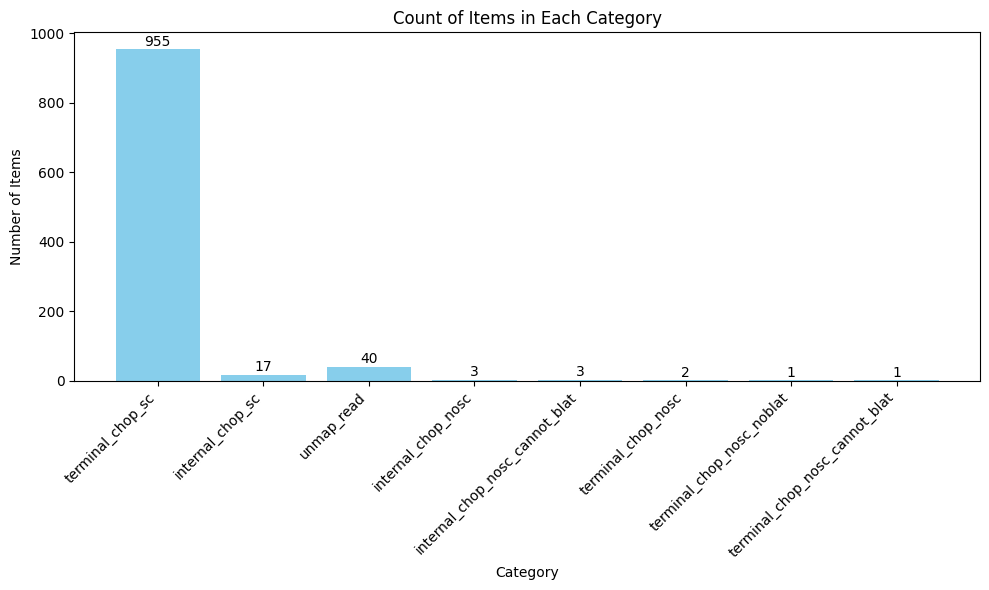

In [ ]:
vis_overlap_results(overlap_results)

In [45]:
# overlap_results
for key, values in overlap_results.items():
    if key not in ["internal_chop_sc",  "terminal_chop_sc", "unmap_read"]:
        for value in values:
            print(f"\n{key}")
            pd = all_predicts[value]
            
            verify_result_with_sam_records(
            defaultdict(list),
            pd,
            stats,
            sam_records,
            internal_threshold = 0.85,
            overlap_threshold  = 0.4,
            blat_threshold  = 0.9,
            min_mapping_quality = 0)
        
            # show_sam_record(pd, stats, sam_records)

Tue Apr 23 16:06:11 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.



internal_chop_nosc


id: d8ca108a-9cb0-467b-98a6-93a3be0b7c4d
prediction: [193..264, 610..683]
smooth_intervals: [(193, 264), (610, 683)]
TTCCCGGACGTCTAAACCAAACCACTTCACCGCAACACGACCGGGGGTATACTACGGTCAATGCTCTGGCTTGTGGAGCA
AACCACAGTTTCTCGCCCATCGTCCTAGAATTAATTCCCCTAAAAATTTTTGAAATAGGGCCCGTATTTACCCTATAGTC
TCCCCTCTACCCCCTCTGGAGCCAAAAAAAAAATCCCCCACCTACCCCACTTTACCACTCCTACCATCTTATCCATCTTC
TCCCTCCACAACACCTAAACCCCCTTAATTTTAATAATCAACACCCTCCAGCCTTACTACTAATAATTATACATTTTGAC
TACCTATTCATGCAATACATAGAAAAATCCACCCCTTACGAGTGCGGCTTCGACCCTATATCCCCCGCCCGCGTCCCTTT
CTCCATAAAATTCTTCTTAGTAGCTATTACCTTCTTATATTATTGATCTAGAAATTGCCCTCCTTTTACCCTACCATGAG
CCCTACAAACAACTAACCTGCCACTAATAGTTATGTCAACCCCTCTTATTAATCATCATCAGCCCTAAGTCTGGCCTATG
AGTGACTACAAAAAGGATTAGACTGAGCCGAATAAAAAAAAAAAAAAAAATCCCTACCTCCCACACACTCCCACCGTCAT
CTTATCCATTACACATCCGCCCTCCCATCACATCCTATCACCC

TTCCCGGACGTCTAAACCAAACCACTTCACCGCAACACGACCGGGGGTATACTACGGTCAATGCTCTGGCTTGTGGAGCA
AACCACAGTTTCTCGCCCATCGTCCTAGAATTAATTCCCCTAAAAATTTTTGAAATAGGGCCCGTATTTACCCTATAGTC
TCCCCT

Tue Apr 23 16:06:11 2024 INFO Sequence recognized as nucleotide sequence. 'seqtype' will be set as DNA.



blat_df:   genome  query_size  aligned_start  aligned_end  matches  mismatches  %_aligned  %_matched chromosome strand      start        end
0   hg38          71             32           60       26           1      40.85      89.66       chr8      +  107699365  107699391
1   hg38          71             31           55       24           0      35.21      96.00       chr7      +  110044097  110044122
2   hg38          71             38           60       23           0      32.39     100.00       chr4      +  119595595  119595623

compare (593, 683)(90) (610, 683)(73) ratio=1.0

internal_chop_nosc_noblat


id: d8ca108a-9cb0-467b-98a6-93a3be0b7c4d
prediction: [193..264, 610..683]
smooth_intervals: [(193, 264), (610, 683)]
TTCCCGGACGTCTAAACCAAACCACTTCACCGCAACACGACCGGGGGTATACTACGGTCAATGCTCTGGCTTGTGGAGCA
AACCACAGTTTCTCGCCCATCGTCCTAGAATTAATTCCCCTAAAAATTTTTGAAATAGGGCCCGTATTTACCCTATAGTC
TCCCCTCTACCCCCTCTGGAGCCAAAAAAAAAATCCCCCACCTACCCCACTTTACCACTCCTACCATCTTATCCATCTTC
TCCCTCCACAACACCTAAACCCCC